# Load data

This is a special analysis for the X chromosome. We look at

* DEL male (0, 1, 2) in PAR (1, 2) everywhere else
* DEL female (0, 1, 2)
* TDT (only from mom)

Combining male and female DEL is challenging since we know sex is associated with affected status and deletions will also be associated with affected status in non-PAR regions. TDT is ok because we ignore singledel_paternal in males.


In [276]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


In [277]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [278]:
chrom = 'X'
family_sizes = [3, 4, 5, 6, 7]
phase_dir = '../phased'
data_dir = '../split_gen'

PAR1X = (60001, 2699520)
PAR2X = (154931044, 155260560)

In [279]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    chrom_length = 0
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
            chrom_length = max(chrom_length, int(pieces[1]), int(pieces[2]))

In [280]:
import numpy as np
clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
max_index = snp_positions.shape[0]


In [281]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()

fams = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        num_fams_of_size = 0
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            fams.add(family_key)
            num_fams_of_size += 1
        print('%d families of size %d' % (num_fams_of_size, j))
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]
            
            if len([x for x in inheritance_state if x is None]) == 0:
                
                doubledel, singledel, nodel = [], [], []
                singledel_mat, singledel_pat = [], []

                # children
                for k, child_id in enumerate(individuals[2:]):
                    mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]

                    if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                        doubledel.append(child_id)
                    elif inheritance_state[mat] == 1:
                        singledel_mat.append(child_id)
                    elif inheritance_state[2+pat] == 1:
                        singledel_pat.append(child_id)
                    else:
                        nodel.append(child_id)
                    if inheritance_state[mat] == 1 or inheritance_state[2+pat] == 1:
                        singledel.append(child_id)

                deletions.append(Deletion(family_key, chrom,
                                              start_pos, end_pos, start_index, end_index, length,
                                              inheritance_state, individuals,
                                              doubledel, singledel, nodel,
                                              singledel_mat, singledel_pat))
        
                
print('Chrom', chrom, 'total families', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))



18 families of size 3
436 families of size 4
356 families of size 5
57 families of size 6
7 families of size 7
Chrom X total families 874
deletions 180006 maternal 155000 paternal 224951


In [282]:
print('Maternal inheritance rate', sum([len(x.singledel_maternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[:2]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[:2]) == 1]))
print('Paternal inheritance rate', sum([len(x.singledel_paternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[2:4]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[2:4]) == 1]))



Maternal inheritance rate 0.6389604810996563
Paternal inheritance rate 0.7465638950586062


# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [283]:
in_par = np.zeros((max_index,), dtype=int)
in_par[(snp_positions >= PAR1X[0]) & (snp_positions <= PAR1X[1])] = 1
in_par[(snp_positions >= PAR2X[0]) & (snp_positions <= PAR2X[1])] = 1 

In [284]:
# Create contingency tables for each comparison
# position, deletion, affected, sex
del_conting_t = np.zeros((max_index+1, 3, 2, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2, 2), dtype=int)  

for d in deletions:
    for x in d.doubledel:
        sex = int(child_id_to_sex[x] != '1')
        affected = int(child_id_to_affected[x] != '2')
        del_conting_t[d.start_index:(d.end_index+1), 0, affected, sex] += 1
    for x in d.singledel:
        sex = int(child_id_to_sex[x] != '1')
        affected = int(child_id_to_affected[x] != '2')
        del_conting_t[d.start_index:(d.end_index+1), 1, affected, sex] += 1
    for x in d.nodel:
        sex = int(child_id_to_sex[x] != '1')
        affected = int(child_id_to_affected[x] != '2')
        del_conting_t[d.start_index:(d.end_index+1), 2, affected, sex] += 1
  
    if sum(d.inheritance_state[:2]) == 1:
        # mom
        for x in d.doubledel + d.singledel_maternal:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[d.start_index:(d.end_index+1), 0, affected, sex] += 1
        
        for x in d.singledel_paternal+d.nodel:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[d.start_index:(d.end_index+1), 1, affected, sex] += 1
            
    if in_par[d.start_index] == 1 and in_par[d.end_index] == 1 and sum(d.inheritance_state[2:4]) == 1:
        # dad
        for x in d.doubledel + d.singledel_paternal:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[d.start_index:(d.end_index+1), 0, affected, sex] += 1
        
        for x in d.singledel_maternal+d.nodel:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[d.start_index:(d.end_index+1), 1, affected, sex] += 1
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total_unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)


total affected 1831 total_unaffected 390
total families 874


In [285]:
# find indices of changes
del_male_diff = np.sum(np.abs(del_conting_t[1:, :, :, 0] - del_conting_t[:-1, :, :, 0]), axis=(1, 2))
del_female_diff = np.sum(np.abs(del_conting_t[1:, :, :, 1] - del_conting_t[:-1, :, :, 1]), axis=(1, 2))
tdt_male_diff = np.sum(np.abs(tdt_conting_t[1:, :, :, 0] - tdt_conting_t[:-1, :, :, 0]), axis=(1, 2))
tdt_female_diff = np.sum(np.abs(tdt_conting_t[1:, :, :, 1] - tdt_conting_t[:-1, :, :,1]), axis=(1, 2))

indices = np.where((del_male_diff>0) | (del_female_diff>0) | (tdt_male_diff>0) | (tdt_female_diff>0))[0]

In [294]:
from scipy.stats import chi2_contingency

# calculate pvalues for every point
del_pvalues = np.ones((max_index+1,))
del_male_pvalues = np.ones((max_index+1,))
del_female_pvalues = np.ones((max_index+1,))
tdt_pvalues = np.ones((max_index+1,))
tdt_male_pvalues = np.ones((max_index+1,))
tdt_female_pvalues = np.ones((max_index+1,))

num_tests = 0

prev_i = 0
for i in indices:
    # DEL
    dc = del_conting_t[i, :2, :, 0] + del_conting_t[i, 1:, :, 1]
    dc = dc[np.ix_(np.sum(dc, axis=1)>10, np.sum(dc, axis=0)>10)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
        num_tests += 1
    else:
        del_pvalue = 1
        
    del_pvalues[prev_i:i] = del_pvalue
    
    # DEL male
    dc = del_conting_t[i, :, :, 0]
    dc = dc[np.ix_(np.sum(dc, axis=1)>10, np.sum(dc, axis=0)>10)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
        num_tests += 1
    else:
        del_pvalue = 1
        
    del_male_pvalues[prev_i:i] = del_pvalue
    
    # DEL female
    dc = del_conting_t[i, :, :, 1]
    dc = dc[np.ix_(np.sum(dc, axis=1)>10, np.sum(dc, axis=0)>10)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
        num_tests += 1
    else:
        del_pvalue = 1
        
    del_female_pvalues[prev_i:i] = del_pvalue

    # TDT
    tc = tdt_conting_t[i, :, :, 0] + tdt_conting_t[i, :, :, 1]
    tc = tc[np.ix_(np.sum(tc, axis=1)>10, np.sum(tc, axis=0)>10)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
        num_tests += 1
    else:
        tdt_pvalue = 1
        
    tdt_pvalues[prev_i:i] = tdt_pvalue
    
    # TDT male
    tc = tdt_conting_t[i, :, :, 0]
    tc = tc[np.ix_(np.sum(tc, axis=1)>10, np.sum(tc, axis=0)>10)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
        num_tests += 1
    else:
        tdt_pvalue = 1
        
    tdt_male_pvalues[prev_i:i] = tdt_pvalue
    
    # TDT female
    tc = tdt_conting_t[i, :, :, 1]
    tc = tc[np.ix_(np.sum(tc, axis=1)>10, np.sum(tc, axis=0)>10)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
        num_tests += 1
    else:
        tdt_pvalue = 1
        
    tdt_female_pvalues[prev_i:i] = tdt_pvalue

    prev_i = i

In [295]:
num_bases_with_del = np.sum(num_people > 0)
print(num_bases_with_del, num_bases_with_del/snp_positions[-1])

2005760 0.0129186791318


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


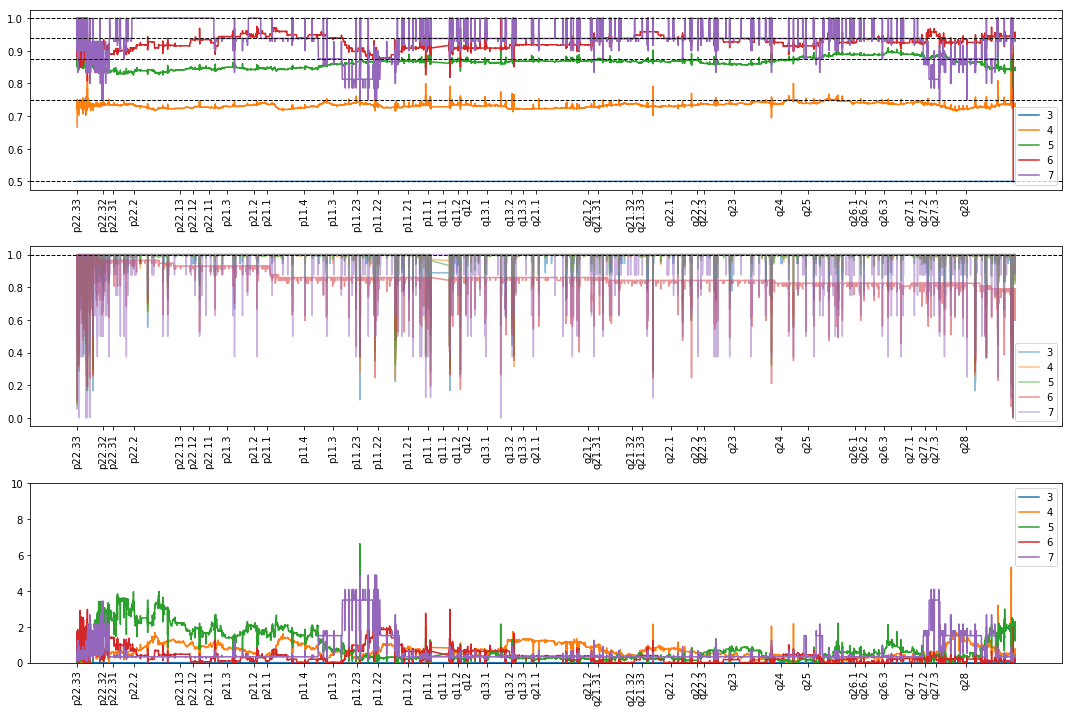

In [299]:
from scipy.stats import chisquare

plt.figure(figsize=(15, 10))
inh_ps = [0]*(max(family_sizes)+1)
for j in family_sizes:
    inherited = np.zeros((max_index+1,), dtype=int)
    not_inherited = np.zeros((max_index+1,), dtype=int)

    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            
            if len([x for x in inheritance_state if x is None]) == 0:
                
                m1_inh, m2_inh = 0, 0
                for k, s in enumerate(inheritance_state[4:]):
                    if k % 2 == 0:
                        m1_inh += (s==0)
                        m2_inh += (s==1)
                        
                num_inherited = (m1_inh>0) + (m2_inh>0)
                inherited[start_index:(end_index+1)] += num_inherited
                not_inherited[start_index:(end_index+1)] += 2 - num_inherited

        plt.subplot(3, 1, 1)
        plt.plot(snp_positions[indices], (inherited/(inherited+not_inherited))[indices], label=str(j))
        plt.subplot(3, 1, 2)
        plt.plot(snp_positions[indices], (inherited[indices]+not_inherited[indices])/np.max(inherited+not_inherited), label=str(j), alpha=0.5)
        
        # calc pvalues
        inh_ps[j] = np.ones((max_index+1,))
        for i in indices:
            p_not_inherited = pow(0.5, j-2)
            inh, notinh = inherited[i], not_inherited[i]
            total = inh+notinh
            inh_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
        plt.subplot(3, 1, 3)
        plt.plot(snp_positions[indices], -np.log10(inh_ps[j][indices]), label=str(j))
        
plt.subplot(3, 1, 1)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(3, 1, 2)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(3, 1, 3)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

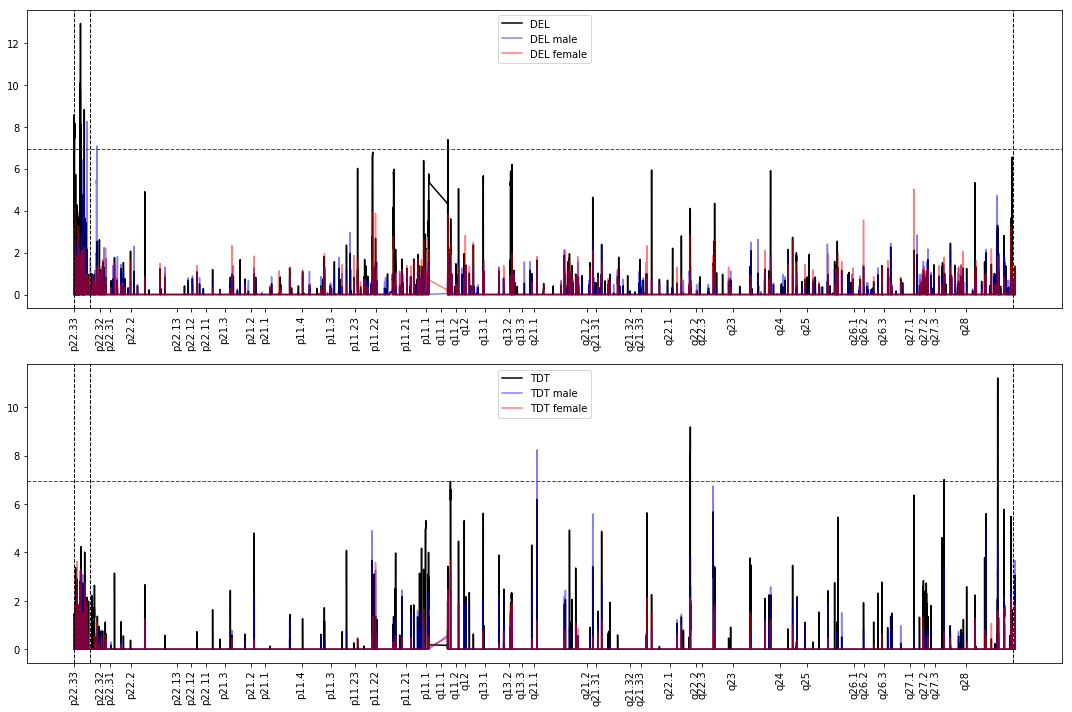

In [296]:
# plot pvalues
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)   
plt.plot(snp_positions[indices], -np.log10(del_pvalues[indices]), label='DEL', color='black')
plt.plot(snp_positions[indices], -np.log10(del_male_pvalues[indices]), alpha=0.5, label='DEL male', color='blue')
plt.plot(snp_positions[indices], -np.log10(del_female_pvalues[indices]), alpha=0.5, label='DEL female', color='red')

plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(2, 1, 2) 
plt.plot(snp_positions[indices], -np.log10(tdt_pvalues[indices]), label='TDT', color='black')
#plt.plot(snp_positions[indices], -np.log10(tdt_peak_pvalues[indices]), alpha=0.5, label='TDT peaks')
plt.plot(snp_positions[indices], -np.log10(tdt_male_pvalues[indices]), alpha=0.5, label='TDT male', color='blue')
plt.plot(snp_positions[indices], -np.log10(tdt_female_pvalues[indices]), alpha=0.5, label='TDT female', color='red')

plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()

In [298]:
def print_peaks(pvalues, label, comp=None):
    p = -np.log10(pvalues)[indices]
    cutoff = -np.log10(0.01/num_tests)
    hit_start_indices = np.where((p[:-1] < cutoff) & (p[1:] >= cutoff))[0]
    hit_end_indices = np.where((p[:-1] >= cutoff) & (p[1:] < cutoff))[0]
    peaks = []
    for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
        hit_start, hit_end = indices[hit_start], indices[hit_end]
        start_pos, end_pos = int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1])
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        peak = (int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]))
        peaks.append(peak)
        star = '*' if comp is not None and peak in comp else ''            
        print(star + label, end_pos-start_pos, start_pos, end_pos, xticklabels[cyto], sep='\t')
    return peaks

dp = set(print_peaks(del_pvalues, 'DEL\t'))
tp = set(print_peaks(tdt_pvalues, 'TDT\t'))

print_peaks(del_male_pvalues, 'DEL male', comp=dp)
print_peaks(del_female_pvalues, 'DEL female', comp=dp)

print_peaks(tdt_male_pvalues, 'TDT male', comp=tp)
print_peaks(tdt_female_pvalues, 'TDT female', comp=tp)

DEL		851	85412	86263	p22.33
DEL		86	86270	86356	p22.33
DEL		305	87706	88011	p22.33
DEL		64	88021	88085	p22.33
DEL		208	88113	88321	p22.33
DEL		115	88338	88453	p22.33
DEL		20	88474	88494	p22.33
DEL		11	88519	88530	p22.33
DEL		489	88557	89046	p22.33
DEL		308	91216	91524	p22.33
DEL		414	91530	91944	p22.33
DEL		1536	92198	93734	p22.33
DEL		30	93833	93863	p22.33
DEL		1473	144876	146349	p22.33
DEL		17	146418	146435	p22.33
DEL		22	146609	146631	p22.33
DEL		1191	147089	148280	p22.33
DEL		97	1040209	1040306	p22.33
DEL		3478	1040309	1043787	p22.33
DEL		63	1044046	1044109	p22.33
DEL		16	1044118	1044134	p22.33
DEL		246	1044142	1044388	p22.33
DEL		1181	1044434	1045615	p22.33
DEL		2	1098315	1098317	p22.33
DEL		114	1098318	1098432	p22.33
DEL		1393	1103026	1104419	p22.33
DEL		1074	1110255	1111329	p22.33
DEL		402	1127547	1127949	p22.33
DEL		1600	1128015	1129615	p22.33
DEL		467	1129631	1130098	p22.33
DEL		154	1130222	1130376	p22.33
DEL		118	1130904	1131022	p22.33
DEL		387	1131491	1131878	p22.33
DEL		33	

[]

In [259]:
start, end = sorted(tp)[1]
start_index, end_index = np.where(snp_positions==start)[0][0], np.where(snp_positions==end)[0][0]
print(start_index, end_index)
c = np.sum(del_conting_t[int(start_index+0.5*(end_index-start_index)), :, :, :], axis=2)
print(c)
print(c/np.sum(c, axis=0))
c = np.sum(del_conting_t[start_index:end_index, :, :, :], axis=(0, 3))
print(c/np.sum(c, axis=0))

2610318 2610319
[[  13    2]
 [1343  176]
 [ 378  182]]
[[ 0.00749712  0.00555556]
 [ 0.7745098   0.48888889]
 [ 0.21799308  0.50555556]]
[[ 0.00749712  0.00555556]
 [ 0.7745098   0.48888889]
 [ 0.21799308  0.50555556]]


In [ ]:
del_conting_t_norm = np.zeros(del_conting_t.shape)

for i in range(2):
    for j in range(2):
        norm_term = np.sum(del_conting_t[:, :, i, j], axis=1)
        del_conting_t_norm[norm_term > 0, :, i, j] = (del_conting_t[norm_term > 0, :, i, j].T/norm_term[norm_term > 0]).T

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 0, 0, 0], label='dd male affected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 1, 0, 0], label='sd male affected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 2, 0, 0], label='nd male affected', alpha=0.5)

plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.ylim([0, 1])
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 0, 1, 0], label='dd male unaffected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 1, 1, 0], label='sd male unaffected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 2, 1, 0], label='nd male unaffected', alpha=0.5)

plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.ylim([0, 1])
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 0, 0, 1], label='dd female affected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 1, 0, 1], label='sd female affected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 2, 0, 1], label='nd female affected', alpha=0.5)

plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.ylim([0, 1])
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 0, 1, 1], label='dd female unaffected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 1, 1, 1], label='sd female unaffected', alpha=0.5)
plt.plot(snp_positions[indices], del_conting_t_norm[indices, 2, 1, 1], label='nd female unaffected', alpha=0.5)

plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()